# Chambord Stones Project

## Overview
This project demonstrates an automatic mask generation process using deep learning techniques. We apply a segmentation model to detect and create masks for stone structures in images. The workflow includes environment setup, image processing, mask generation with the SAM model, and visualization of both intermediate and final results.

### Step 1: Set-Up Environment

In this section, we import the necessary libraries:
- **NumPy** for numerical operations.
- **Matplotlib** for plotting and visualization.
- **OpenCV (cv2)** for image processing.
- **Supervision** for enhanced annotation of results.


In [6]:
import numpy as np 
# import torch
import matplotlib.pyplot as plt 
import cv2
# import math
import supervision as sv

In [7]:
import importlib

libraries = ["numpy", "torch", "matplotlib", "cv2", "math", "supervision"]

for lib in libraries:
    try:
        importlib.import_module(lib)
        print(f"{lib} ✅ Installed")
    except ImportError:
        print(f"{lib} ❌ NOT Installed")

numpy ✅ Installed
torch ✅ Installed
matplotlib ✅ Installed
cv2 ✅ Installed
math ✅ Installed
supervision ✅ Installed


### Step 2: Define Utility Functions

We define a helper function `show_anns` that overlays the generated masks on the image.

In [8]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

### Step 3: Load and Display the Image

Here, we load the target image using OpenCV, convert its color space from BGR to RGB, and display it using Matplotlib.

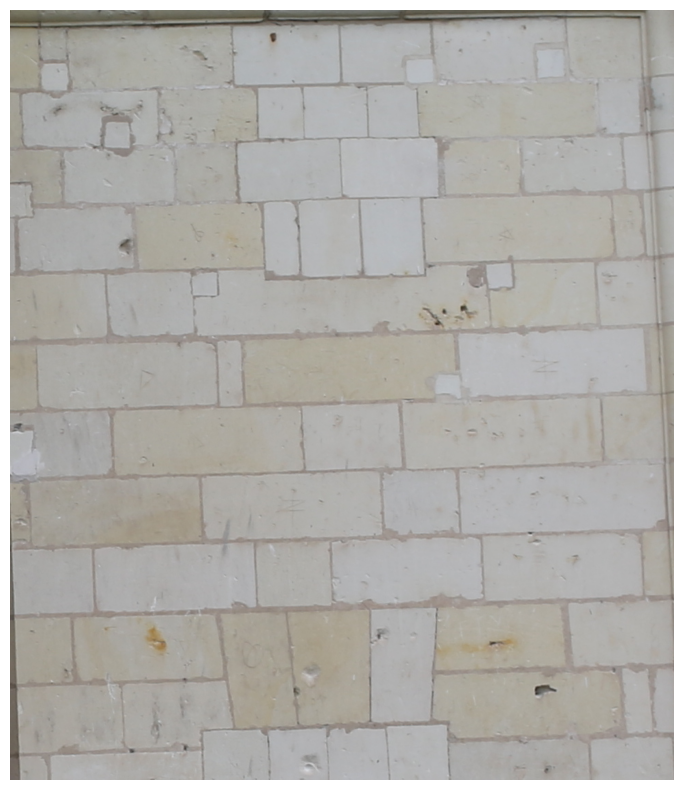

In [10]:
image = cv2.imread('../data/refined/img-stones/FSE_35_001.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

### Step 4: Initialize the SAM Model for Mask Generation

In this section, we import additional modules and initialize the Segment Anything Model (SAM) for automatic mask generation. We load the pre-trained weights and configure the model on the selected device (CPU in this example).

In [11]:
import sys
sys.path.append("../third_party/segment-anything/")  
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor


sam_checkpoint = "../models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

### Step 5: Generate and Explore Masks

We generate segmentation masks using the initialized SAM model and then examine the number of masks along with the keys of the first mask to understand its structure.

In [12]:
masks = mask_generator.generate(image)

In [13]:
print(len(masks))
print(masks[0].keys())

135
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


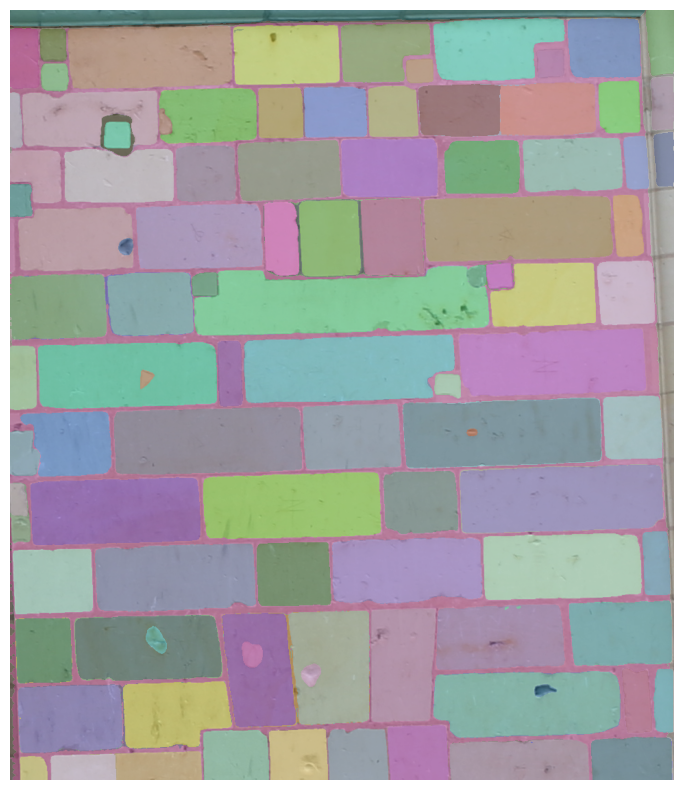

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

### Mask Data Structure Explanation

Mask generation returns a list of masks, where each mask is a dictionary containing:
- **segmentation**: the binary mask.
- **area**: the area of the mask in pixels.
- **bbox**: the bounding box in XYWH format.
- **predicted_iou**: the model’s predicted quality of the mask.
- **point_coords**: the sampled input point for generating the mask.
- **stability_score**: an additional quality measure.
- **crop_box**: the crop of the image used for mask generation.

### Show All Masks Overlayed on the Image

This section overlays all generated masks on the original image to visually verify the segmentation results.

### Step 6: Automatic Mask Generation Options

We configure an alternative mask generator with different parameters to generate more refined masks. These parameters control point sampling, thresholding for mask quality, and post-processing steps.

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=128,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [16]:
masks2 = mask_generator_2.generate(image)

In [17]:
len(masks2)

137

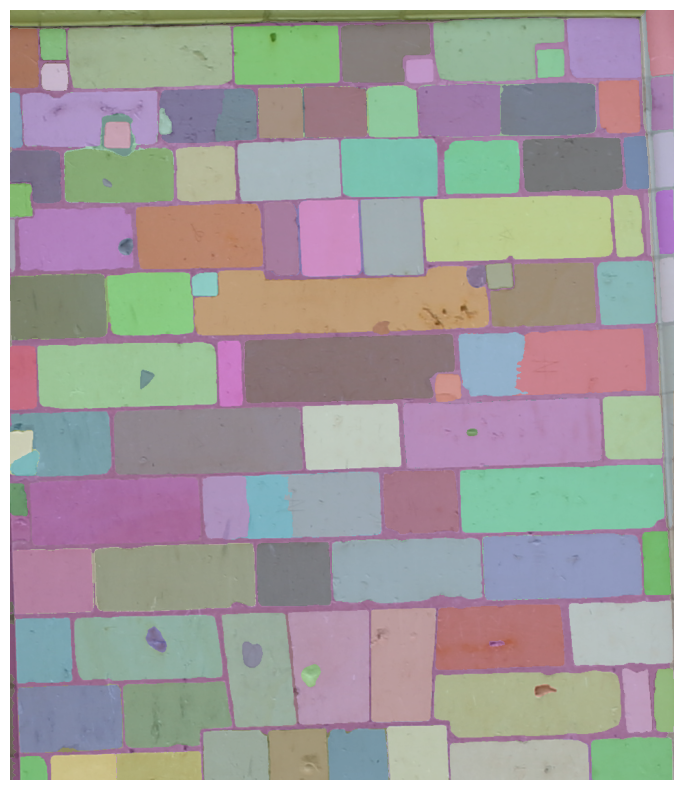

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 

### Step 7: Build the Final Binary Mask

We combine the individual segmentation masks into one consolidated binary mask. This involves aggregating the masks, applying thresholding, and visualizing the result to ensure a clean final mask.

In [1]:
def build_totalmask(pred):
    """
    Combine SAM masks using logical OR, apply morphological opening
    to separate thin lines, and invert so mortar is white and stones are black.
    """
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    # 1. Create a boolean mask matching the shape of the first segmentation
    height, width = pred[0]['segmentation'].shape
    total_mask_bool = np.zeros((height, width), dtype=bool)
    
    # 2. Combine each segmentation mask with a logical OR
    for seg in pred:
        # seg['segmentation'] is a boolean array
        total_mask_bool = np.logical_or(total_mask_bool, seg['segmentation'])
    
    # 3. Convert boolean mask to uint8 (0 or 255)
    total_mask_uint8 = total_mask_bool.astype(np.uint8) * 255
    
    # 4. Apply a small morphological open to keep mortar lines distinct
    #    (If lines are still merged, try a bigger kernel or use morphological close differently)
    kernel = np.ones((2, 2), np.uint8)
    total_mask_uint8 = cv2.morphologyEx(total_mask_uint8, cv2.MORPH_OPEN, kernel)
    
    # 5. Invert the mask: now mortar lines are white (255), stones are black (0)
    total_mask_uint8 = cv2.bitwise_not(total_mask_uint8)

    # 6. (Optional) Display the final mask for verification
    plt.figure(figsize=(8,8))
    plt.imshow(total_mask_uint8, cmap='gray')
    plt.title("Final Mask: Mortar White, Stones Black")
    plt.axis('off')
    plt.show()

    return total_mask_uint8


White pixels %: 22.06% | White px: 14460
White pixels %: 38.49% | White px: 25226
White pixels %: 25.17% | White px: 16494
White pixels %: 15.46% | White px: 10134
White pixels %: 35.78% | White px: 23450
White pixels %: 36.83% | White px: 24137
White pixels %: 36.1% | White px: 23656
White pixels %: 9.33% | White px: 6117
White pixels %: 19.64% | White px: 12870
White pixels %: 10.3% | White px: 6749
White pixels %: 29.16% | White px: 19109
White pixels %: 9.51% | White px: 6231
White pixels %: 16.46% | White px: 10785
White pixels %: 25.22% | White px: 16528
White pixels %: 32.58% | White px: 21352
White pixels %: 40.82% | White px: 26751
White pixels %: 27.19% | White px: 17820
White pixels %: 28.94% | White px: 18968
White pixels %: 19.5% | White px: 12782
White pixels %: 22.99% | White px: 15065
White pixels %: 18.86% | White px: 12362
White pixels %: 10.85% | White px: 7110
White pixels %: 34.63% | White px: 22696
White pixels %: 16.11% | White px: 10560
White pixels %: 40.44% | 

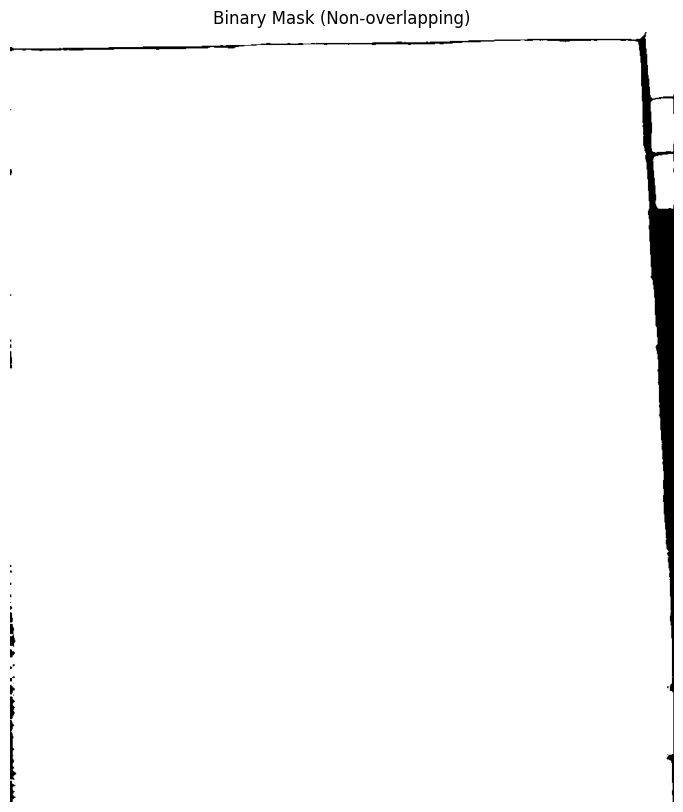

True

In [21]:
# Use the SAM masks to build the final binary mask.
# You can choose to use either `masks` or `masks2` depending on your needs.
total_mask = build_totalmask(masks)

# Save the binary mask to a file
cv2.imwrite('binary_mask.png', total_mask)

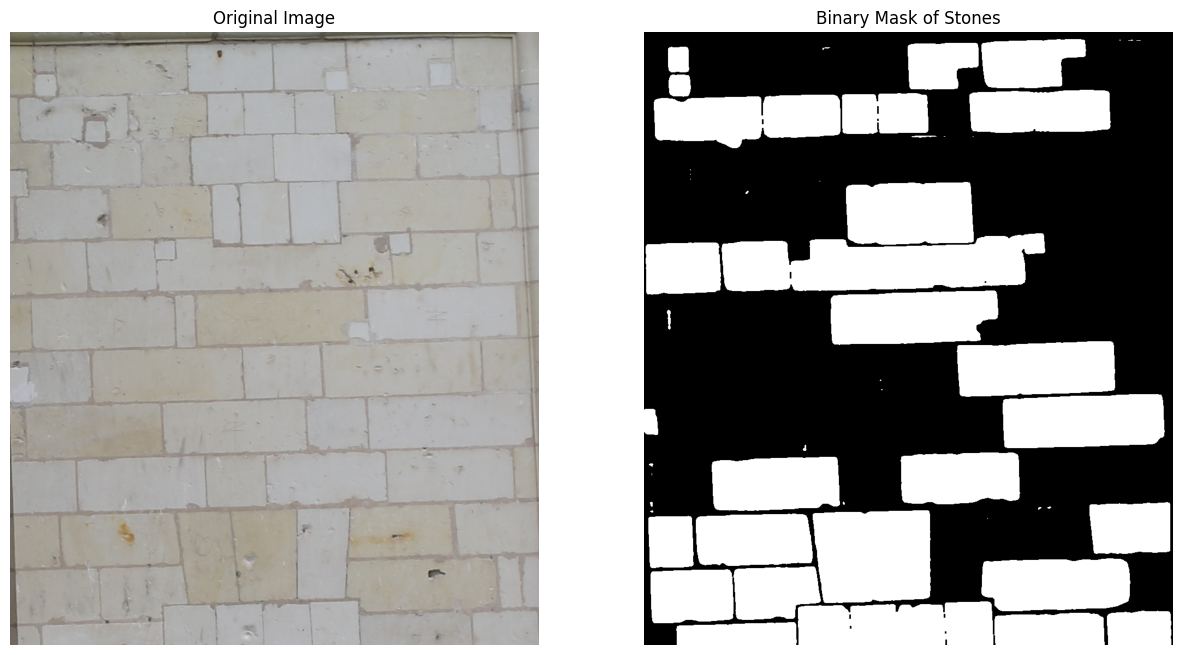

In [26]:
# Optional: Display the original image alongside the binary mask
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(total_mask, cmap='gray')
plt.title("Binary Mask of Stones")
plt.axis('off')
plt.show()

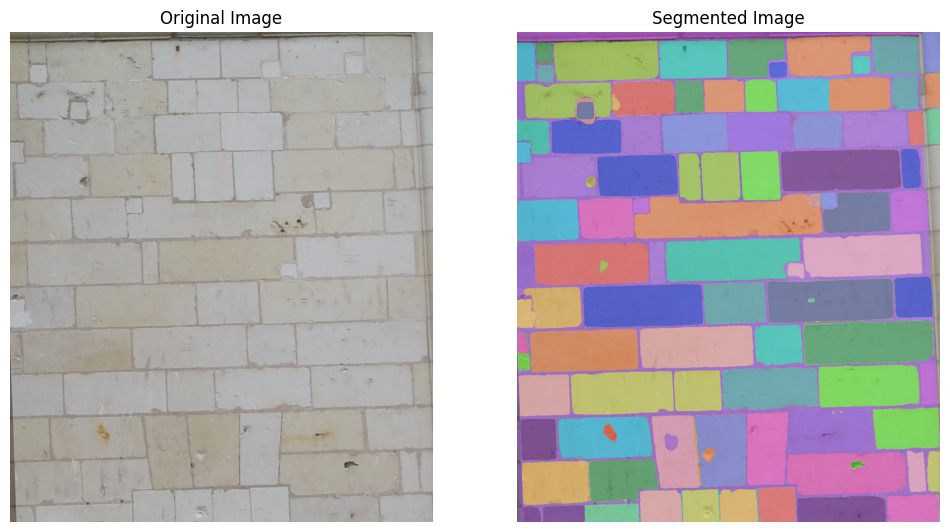

In [23]:
image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=masks)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['Original Image', 'Segmented Image']
)

### Step 8: Process All Raw Images (FSE and FNE)

Now that our SAM model and `build_totalmask` function are working for a single image, 
let's extend the process to *all* images inside the `img-FSE` and `img-FNE` folders. 
We'll create 256×256 patches from every image, saving only those that contain enough stone pixels.


Found 9 images to process.
Processing ../data/refined/img-stones/FSE_35_008.jpg ...
White pixels %: 22.75% | White px: 14907
White pixels %: 8.83% | White px: 5787
White pixels %: 27.14% | White px: 17784
White pixels %: 8.21% | White px: 5379
White pixels %: 11.69% | White px: 7661
White pixels %: 11.7% | White px: 7669
White pixels %: 6.96% | White px: 4564
White pixels %: 11.48% | White px: 7522
White pixels %: 26.95% | White px: 17665
White pixels %: 11.72% | White px: 7679
White pixels %: 9.92% | White px: 6501
White pixels %: 20.69% | White px: 13558
White pixels %: 10.4% | White px: 6816
White pixels %: 26.96% | White px: 17671
White pixels %: 22.37% | White px: 14661
White pixels %: 22.35% | White px: 14650
White pixels %: 22.12% | White px: 14497
White pixels %: 22.2% | White px: 14548
White pixels %: 11.7% | White px: 7665
White pixels %: 23.33% | White px: 15290
White pixels %: 7.07% | White px: 4633
White pixels %: 23.19% | White px: 15196
White pixels %: 2.84% | White px: 

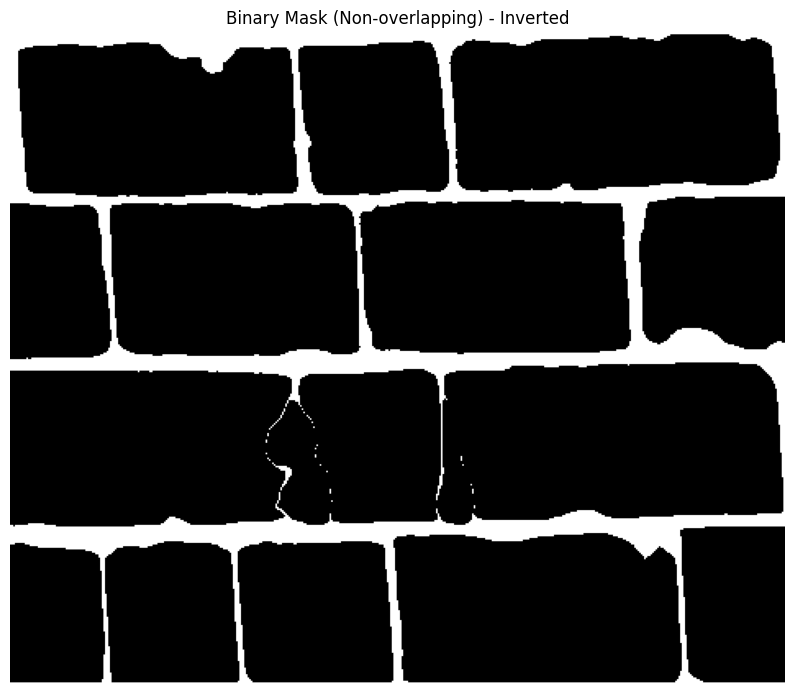

Processing ../data/refined/img-stones/FSE_35_010.jpg ...
White pixels %: 22.99% | White px: 15067
White pixels %: 26.92% | White px: 17644
White pixels %: 13.7% | White px: 8976
White pixels %: 12.41% | White px: 8132
White pixels %: 2.92% | White px: 1913
White pixels %: 27.51% | White px: 18027
White pixels %: 20.92% | White px: 13711
White pixels %: 463.92% | White px: 304033
White pixels %: 22.76% | White px: 14916
White pixels %: 28.61% | White px: 18750
White pixels %: 22.71% | White px: 14885
White pixels %: 20.3% | White px: 13304
White pixels %: 21.43% | White px: 14044
White pixels %: 27.49% | White px: 18014
White pixels %: 9.31% | White px: 6099
White pixels %: 13.61% | White px: 8918
White pixels %: 20.41% | White px: 13375
White pixels %: 26.26% | White px: 17210
White pixels %: 22.11% | White px: 14489
White pixels %: 21.76% | White px: 14258
White pixels %: 26.41% | White px: 17307
White pixels %: 4.3% | White px: 2820
White pixels %: 20.45% | White px: 13403
White pixe

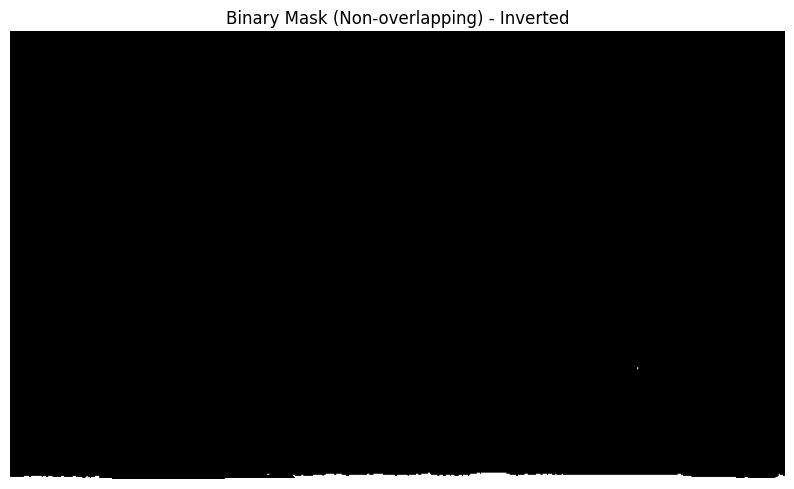

Processing ../data/refined/img-stones/FSE_35_004.jpg ...
White pixels %: 21.74% | White px: 14246
White pixels %: 26.89% | White px: 17623
White pixels %: 26.81% | White px: 17568
White pixels %: 26.94% | White px: 17658
White pixels %: 21.07% | White px: 13810
White pixels %: 25.24% | White px: 16539
White pixels %: 31.36% | White px: 20555
White pixels %: 20.07% | White px: 13156
White pixels %: 17.88% | White px: 11717
White pixels %: 21.1% | White px: 13825
White pixels %: 24.14% | White px: 15821
White pixels %: 354.89% | White px: 232582
White pixels %: 8.29% | White px: 5434
White pixels %: 12.06% | White px: 7904
White pixels %: 12.07% | White px: 7911
White pixels %: 21.14% | White px: 13854
White pixels %: 9.05% | White px: 5931
White pixels %: 12.64% | White px: 8287
White pixels %: 11.31% | White px: 7415
White pixels %: 21.67% | White px: 14202
White pixels %: 1.31% | White px: 858
White pixels %: 27.09% | White px: 17755
White pixels %: 24.6% | White px: 16121
White pixel

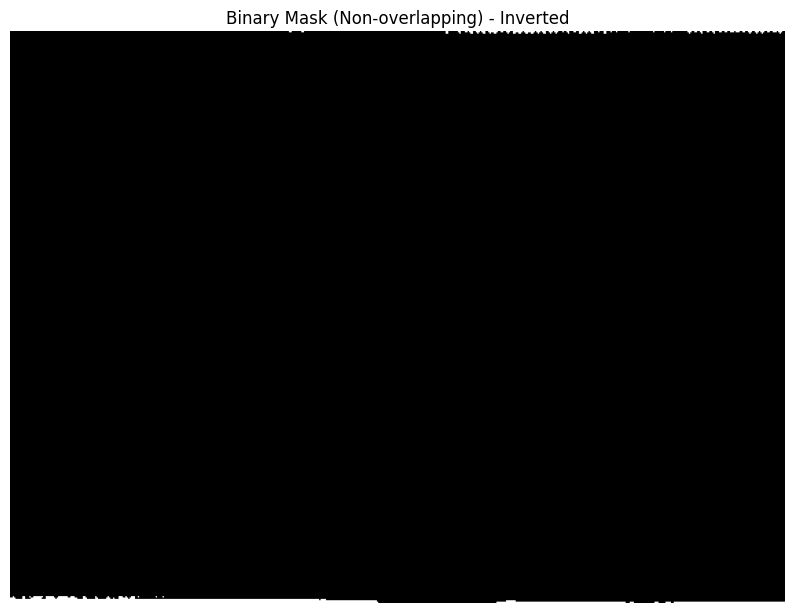

Processing ../data/refined/img-stones/FSE_35_005.jpg ...
White pixels %: 22.67% | White px: 14858
White pixels %: 11.16% | White px: 7317
White pixels %: 16.65% | White px: 10913
White pixels %: 25.16% | White px: 16487
White pixels %: 22.84% | White px: 14967
White pixels %: 26.96% | White px: 17670
White pixels %: 23.61% | White px: 15471
White pixels %: 26.76% | White px: 17536
White pixels %: 11.03% | White px: 7229
White pixels %: 7.69% | White px: 5039
White pixels %: 25.37% | White px: 16629
White pixels %: 24.38% | White px: 15980
White pixels %: 11.69% | White px: 7658
White pixels %: 26.53% | White px: 17386
White pixels %: 10.55% | White px: 6914
White pixels %: 270.56% | White px: 177317
White pixels %: 2.36% | White px: 1544
White pixels %: 4.2% | White px: 2755
White pixels %: 17.51% | White px: 11477
White pixels %: 22.13% | White px: 14503
White pixels %: 6.71% | White px: 4397
White pixels %: 11.58% | White px: 7587
White pixels %: 0.22% | White px: 143
White pixels %:

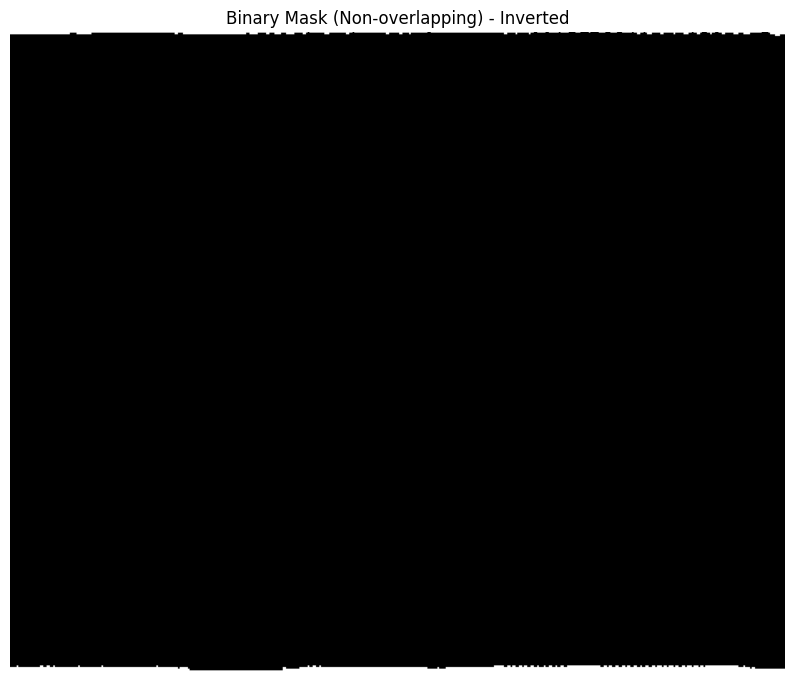

Processing ../data/refined/img-stones/FSE_35_007.jpg ...
White pixels %: 27.24% | White px: 17853
White pixels %: 12.54% | White px: 8217
White pixels %: 26.8% | White px: 17563
White pixels %: 8.67% | White px: 5680
White pixels %: 13.8% | White px: 9041
White pixels %: 23.87% | White px: 15642
White pixels %: 15.0% | White px: 9832
White pixels %: 25.51% | White px: 16718
White pixels %: 13.79% | White px: 9039
White pixels %: 25.96% | White px: 17013
White pixels %: 2.62% | White px: 1716
White pixels %: 11.85% | White px: 7763
White pixels %: 12.42% | White px: 8140
White pixels %: 18.5% | White px: 12127
White pixels %: 15.01% | White px: 9839
White pixels %: 282.04% | White px: 184838
White pixels %: 22.24% | White px: 14574
White pixels %: 2.05% | White px: 1344
White pixels %: 4.83% | White px: 3165
White pixels %: 22.37% | White px: 14658
White pixels %: 10.37% | White px: 6797
White pixels %: 0.85% | White px: 558
White pixels %: 26.1% | White px: 17105
White pixels %: 25.52%

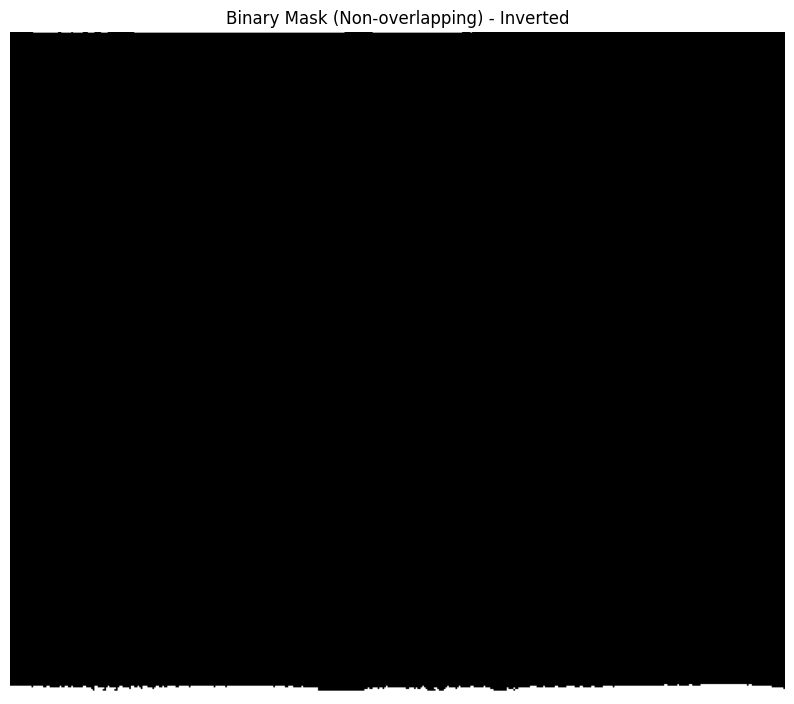

Processing ../data/refined/img-stones/FSE_35_006.jpg ...
White pixels %: 16.55% | White px: 10849
White pixels %: 28.86% | White px: 18915
White pixels %: 20.76% | White px: 13603
White pixels %: 19.14% | White px: 12546
White pixels %: 34.42% | White px: 22557
White pixels %: 6.88% | White px: 4511
White pixels %: 14.5% | White px: 9501
White pixels %: 39.61% | White px: 25959
White pixels %: 4.72% | White px: 3093
White pixels %: 28.63% | White px: 18764
White pixels %: 10.55% | White px: 6917
White pixels %: 14.07% | White px: 9219
White pixels %: 6.96% | White px: 4559
White pixels %: 12.39% | White px: 8122
White pixels %: 7.6% | White px: 4982
White pixels %: 19.09% | White px: 12508
White pixels %: 28.64% | White px: 18767
White pixels %: 34.93% | White px: 22895
White pixels %: 1.61% | White px: 1053
White pixels %: 9.45% | White px: 6192
White pixels %: 0.29% | White px: 190
White pixels %: 17.34% | White px: 11366
White pixels %: 0.55% | White px: 358
White pixels %: 0.18% | 

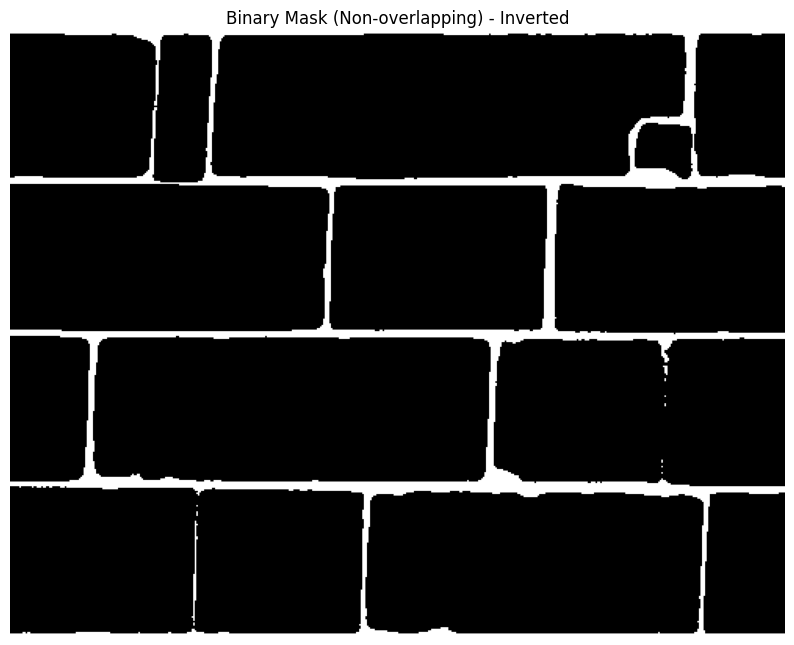

Processing ../data/refined/img-stones/FSE_35_002.jpg ...
White pixels %: 23.56% | White px: 15443
White pixels %: 15.66% | White px: 10262
White pixels %: 27.55% | White px: 18058
White pixels %: 23.73% | White px: 15553
White pixels %: 10.72% | White px: 7026
White pixels %: 19.71% | White px: 12914
White pixels %: 19.49% | White px: 12770
White pixels %: 10.36% | White px: 6787
White pixels %: 17.67% | White px: 11581
White pixels %: 9.91% | White px: 6495
White pixels %: 19.5% | White px: 12781
White pixels %: 19.5% | White px: 12779
White pixels %: 0.98% | White px: 645
White pixels %: 15.67% | White px: 10269
White pixels %: 43.71% | White px: 28649
White pixels %: 20.33% | White px: 13321
White pixels %: 34.14% | White px: 22376
White pixels %: 0.79% | White px: 515
White pixels %: 0.98% | White px: 643
White pixels %: 1.22% | White px: 801
White pixels %: 15.71% | White px: 10296
White pixels %: 43.33% | White px: 28394
White pixels %: 0.32% | White px: 212
White pixels %: 0.15%

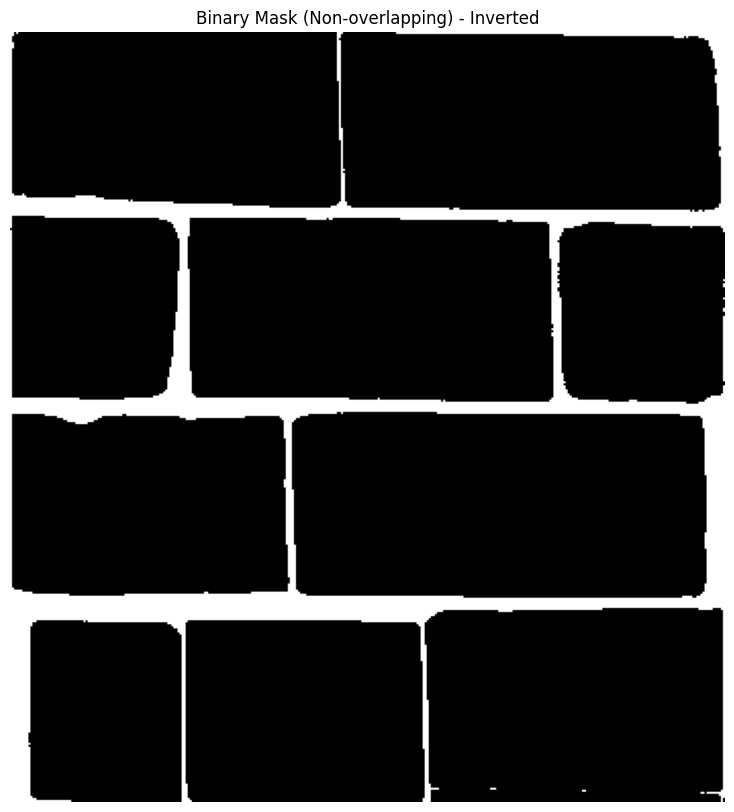

Processing ../data/refined/img-stones/FSE_35_003.jpg ...
White pixels %: 16.75% | White px: 10980
White pixels %: 39.46% | White px: 25863
White pixels %: 21.23% | White px: 13911
White pixels %: 59.28% | White px: 38848
White pixels %: 41.81% | White px: 27400
White pixels %: 4.86% | White px: 3188
White pixels %: 2.44% | White px: 1600
White pixels %: 17.92% | White px: 11747
White pixels %: 4.87% | White px: 3190
White pixels %: 17.89% | White px: 11723
White pixels %: 50.26% | White px: 32936
White pixels %: 10.5% | White px: 6881
White pixels %: 41.15% | White px: 26971
White pixels %: 6.52% | White px: 4273
White pixels %: 50.48% | White px: 33083
White pixels %: 11.2% | White px: 7340
White pixels %: 41.94% | White px: 27483
White pixels %: 41.86% | White px: 27435
White pixels %: 18.58% | White px: 12176
White pixels %: 40.05% | White px: 26246
White pixels %: 0.46% | White px: 300
White pixels %: 6.79% | White px: 4453
White pixels %: 0.88% | White px: 574
White pixels %: 0.68

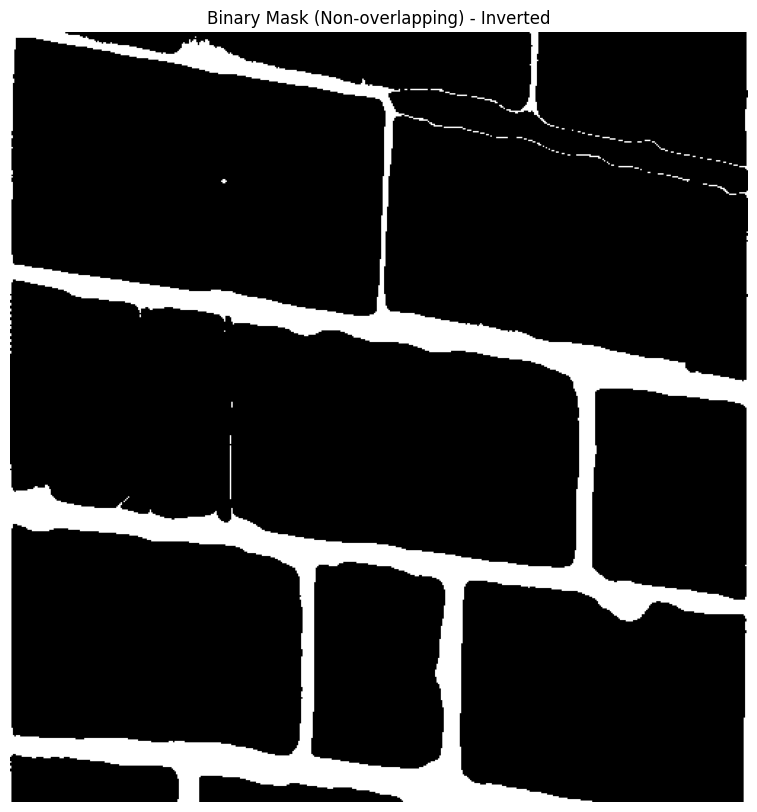

Processing ../data/refined/img-stones/FSE_35_001.jpg ...
White pixels %: 28.49% | White px: 18672
White pixels %: 19.85% | White px: 13010
White pixels %: 40.7% | White px: 26674
White pixels %: 6.1% | White px: 3997
White pixels %: 17.77% | White px: 11643
White pixels %: 12.36% | White px: 8100
White pixels %: 14.96% | White px: 9803
White pixels %: 14.43% | White px: 9455
White pixels %: 28.98% | White px: 18993
White pixels %: 2.7% | White px: 1768
White pixels %: 5.26% | White px: 3447
White pixels %: 12.45% | White px: 8159
White pixels %: 1.41% | White px: 923
White pixels %: 1.64% | White px: 1077
White pixels %: 3.11% | White px: 2035
White pixels %: 0.5% | White px: 329
White pixels %: 20.57% | White px: 13481
White pixels %: 0.22% | White px: 142
White pixels %: 0.98% | White px: 640
White pixels %: 0.27% | White px: 175
White pixels %: 16.11% | White px: 10561
White pixels %: 0.12% | White px: 80
White pixels %: 0.05% | White px: 30


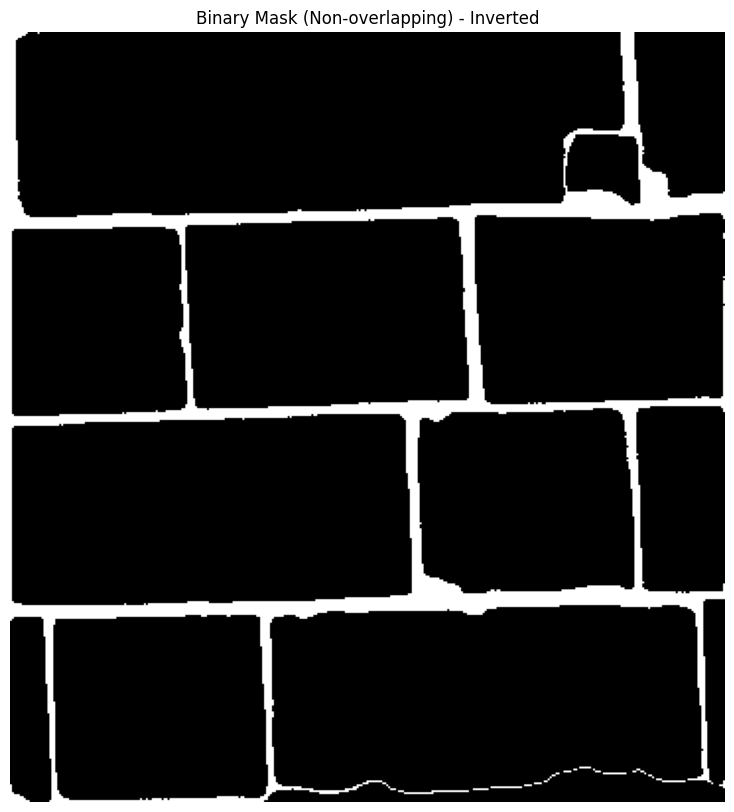

Total patches saved: 344448
	zip warning: name not matched: /kaggle/working/patches

zip error: Nothing to do! (try: zip -r /kaggle/working/patches.zip . -i /kaggle/working/patches)


/Users/jeanhendy/Desktop/chambord-stone-segmentation/notebooks/patches.zip

In [ ]:
import glob
import os
import cv2
import numpy as np

# 1. Gather all stone images
image_paths = glob.glob('../data/refined/img-stones/*.jpg')
print(f"Found {len(image_paths)} images to process.")

# 2. Create an output directory for patches (Kaggle's working directory is writable)
output_dir = '/kaggle/working/patches'
os.makedirs(output_dir, exist_ok=True)

# 3. Patch parameters
patch_size = 256
stride = 128  # Controls overlap; 128 => 50% overlap for 256×256 patches

patch_count = 0

for img_path in image_paths:
    print(f"Processing {img_path} ...")

    # a) Load the image (BGR) -> Convert to RGB
    image_bgr = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # b) Generate masks with your existing SAM model
    #    (Assumes 'mask_generator' is already defined)
    masks = mask_generator.generate(image_rgb)

    # c) Build the final binary mask using the new function
    total_mask = build_totalmask(masks)

    # d) Extract patches (both image and mask)
    height, width = total_mask.shape[:2]
    for y in range(0, height - patch_size + 1, stride):
        for x in range(0, width - patch_size + 1, stride):
            # Extract patch from the original image (RGB)
            patch_img = image_rgb[y:y+patch_size, x:x+patch_size]
            # Extract the corresponding patch from the mask
            patch_mask = total_mask[y:y+patch_size, x:x+patch_size]

            # Convert patch_img to BGR for OpenCV saving
            patch_img_bgr = cv2.cvtColor(patch_img, cv2.COLOR_RGB2BGR)

            # Save the image patch
            cv2.imwrite(os.path.join(output_dir, f'patch_img_{patch_count}.png'),
                        patch_img_bgr)
            # Save the mask patch
            cv2.imwrite(os.path.join(output_dir, f'patch_mask_{patch_count}.png'),
                        patch_mask)

            patch_count += 1

print(f"Total patches saved: {patch_count}")


!zip -r /kaggle/working/patches.zip /kaggle/working/patches
from IPython.display import FileLink
FileLink("patches.zip")
